<a href="https://colab.research.google.com/github/12Brainer/aa-mlp-regresion--S2/blob/main/Q01_Brainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alumnos:
Brainer Fallas Prado

---

In [ ]:
!pip install prettytable

In [ ]:
# General libraries
import numpy as np
import pandas as pd
from prettytable import PrettyTable

# Form Scikit-Learn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score

# Anomalies detection
from sklearn.ensemble import IsolationForest

# From Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Graphics
import matplotlib.pyplot as plt

# Pregunta 1
1. Cargue el dataset de abulones (utilice el PREPROCESADO generado en la tarea anterior).

## Explicación ##
Se usa pandas para crear un dataframe y se muestra su contenido

In [ ]:
# Estadísticas descriptivas
df = pd.read_csv('PREPROCESADO.csv', encoding='utf-8')
print(df)


     Sex_1  Sex_2  Sex_3    Length  Diameter    Height     Whole   Viscera  \
0      1.0    0.0    0.0  0.567164  0.568807  0.369565  0.181335  0.185939   
1      1.0    0.0    0.0  0.410448  0.385321  0.347826  0.079157  0.088807   
2      0.0    1.0    0.0  0.679104  0.669725  0.543478  0.239065  0.260870   
3      1.0    0.0    0.0  0.544776  0.568807  0.500000  0.182044  0.209991   
4      0.0    0.0    1.0  0.380597  0.366972  0.304348  0.071897  0.072155   
..     ...    ...    ...       ...       ...       ...       ...       ...   
979    1.0    0.0    0.0  0.753731  0.798165  0.521739  0.400744  0.473636   
980    1.0    0.0    0.0  0.768657  0.752294  0.630435  0.401629  0.482886   
981    1.0    0.0    0.0  0.768657  0.761468  0.652174  0.426421  0.447734   
982    0.0    1.0    0.0  0.768657  0.733945  0.586957  0.375775  0.451434   
983    0.0    1.0    0.0  0.776119  0.761468  0.630435  0.396317  0.328400   

     Shellweight  ShuckedLabel  Rings  
0       0.147982      0

# Pregunta 2

2. Separe conjunto en X (features) y y (Rings, variable objetivo).


## Explicación ##
Se utiliza un método drop() para eliminar la columna target y definir la matriz X con las features.
Se referencia a la columna "Rings" como columna target.
Se muestran los resultados respectivos.

In [ ]:
X = df.drop(columns=["Rings"])
y = df["Rings"]

print("Features X:")
print(X)
print("Numero features: ", X.shape[1])

print("\nTarget y:")
print(y)

Features X:
     Sex_1  Sex_2  Sex_3    Length  Diameter    Height     Whole   Viscera  \
0      1.0    0.0    0.0  0.567164  0.568807  0.369565  0.181335  0.185939   
1      1.0    0.0    0.0  0.410448  0.385321  0.347826  0.079157  0.088807   
2      0.0    1.0    0.0  0.679104  0.669725  0.543478  0.239065  0.260870   
3      1.0    0.0    0.0  0.544776  0.568807  0.500000  0.182044  0.209991   
4      0.0    0.0    1.0  0.380597  0.366972  0.304348  0.071897  0.072155   
..     ...    ...    ...       ...       ...       ...       ...       ...   
979    1.0    0.0    0.0  0.753731  0.798165  0.521739  0.400744  0.473636   
980    1.0    0.0    0.0  0.768657  0.752294  0.630435  0.401629  0.482886   
981    1.0    0.0    0.0  0.768657  0.761468  0.652174  0.426421  0.447734   
982    0.0    1.0    0.0  0.768657  0.733945  0.586957  0.375775  0.451434   
983    0.0    1.0    0.0  0.776119  0.761468  0.630435  0.396317  0.328400   

     Shellweight  ShuckedLabel  
0       0.147982  

# Pregunta 3

3. Divida el conjunto de datos en datos de entrenamiento, validación y prueba. (1 punto)



## Explicación ##

Se crea una clase concreta para carga de datasets.
Dicha clase luego es utilizada por la función prepare_data(), que a su vez se usa para generar los splits de datos

In [ ]:
class ManageDataset(Dataset):
    """
    Loads and preprocesses a dataset for regression tasks.
    This class extends torch.utils.data.Dataset and includes scaling and
    functionality for splitting the data into train, validation, and test sets.
    """

    def __init__(self, X, y):
        """
        Initializes the dataset with input features and targets, and applies
        MinMax scaling.

        Params:
            X (np.ndarray): Input features.
            y (np.ndarray): Target values.
        """
        self.X = X.astype('float32')
        self.y = y.astype('float32')
        #self.y = y.astype('float32').reshape((len(y), 1))

        self.transformer = MinMaxScaler().fit(self.X)
        self.X = self.transformer.transform(self.X)

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Returns a single sample at the given index.
        Returns a tuple: (X[idx], y[idx])
        Params:
            idx (int): Index of the sample.

        """
        return self.X[idx], self.y[idx]

    def get_splits(self, test_ratio=0.2, val_ratio=0.1):
        """
        Splits the dataset into training, validation, and test sets.
        Returns a tuple: (train_dataset, val_dataset, test_dataset)
        Params:
            test_ratio (float): Proportion of the dataset to reserve for testing (default 0.2).
            val_ratio (float): Proportion of the dataset to reserve for validation (default 0.1).
        """
        total_size = len(self.X)
        test_size = round(test_ratio * total_size)
        val_size = round(val_ratio * total_size)
        train_size = total_size - test_size - val_size

        return random_split(self, [train_size, val_size, test_size])

    def scale_data(self, data_lst):
        """
        Applies the same scaling used in training to a new data record. Returns a
        np.ndarray with scaled input values.
        Params:
            data_lst (list or np.ndarray): Raw input feature values.
        """
        data_array = np.array(data_lst).reshape(1, -1)
        return self.transformer.transform(data_array)

In [ ]:
def prepare_data(X, y, test_ratio=0.2, val_ratio=0.1, batch_size=32):
    """
    Prepares the dataset and returns DataLoaders for training, validation,
    and testing. This function wraps the ManageDataset class and handles
    scaling, splitting, and DataLoader creation. Returns DataLoaders train_dl,
    val_dl, test_dl and the dataset.
    Params:
        X (np.ndarray): Input features.
        y (np.ndarray): Target values.
        test_ratio (float): Proportion of the dataset used for testing. Default is 0.2.
        val_ratio (float): Proportion used for validation. Default is 0.1.
        batch_size (int): Batch size for the DataLoaders.
    """
    # Initialize and scale dataset
    dataset = ManageDataset(X, y)

    # Perform splits
    train_ds, val_ds, test_ds = dataset.get_splits(test_ratio=test_ratio, val_ratio=val_ratio)

    # Create DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_dl, val_dl, test_dl, dataset

In [ ]:
# train, test and validation split
train_dl, test_dl, val_dl, dataset = prepare_data(X, y)

# Pregunta 4

4. Implemente las siguientes arquitecturas de redes neuronales utilizado PyTorch (Incluya una tabla
con los modelos y sus configuraciones). Debe generar 4 modelos (4 puntos):
Comparar cuatro arquitecturas:
• MLP simple: 1 capa oculta
• MLP más profundo: 3 capas ocultas y Dropout.
• Comparar resultados de utilizar funciones de activación: relu, tanh para ambas arquitecturas.

## Explicación ##

Se crea una clase para la instanciación de modelos con parámetros de iniciación como el número de neuronas de la capa de entrada, una lista para las neuronas de las capas internas, una función de activación y un dropout que por defecto es cero. Además, al ser modelos de regresión, la capa de salida está conformada por una única neurona.

Los modelos con función de activación ReLU mostraron mejor desempeño y mayor estabilidad que los modelos con Tanh, especialmente en arquitecturas más simples. Aumentar la profundidad no mejoró significativamente los resultados y, en algunos casos, generó mayor inestabilidad en el entrenamiento. Esto se refleja en la relativa estabilidad del valor de loss

In [ ]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims, activation='relu', dropout=0.0, output_dim=1):
        """
        Parámetros:
        - input_dim: Número de características de entrada.
        - hidden_dims: Lista con los tamaños de cada capa oculta (ej. [64] o [64, 32, 16]).
        - activation: 'relu' o 'tanh'.
        - dropout: Valor de dropout (0.0 para desactivado).
        - output_dim: Número de salidas (1 para regresión).
        """
        super(MLPRegressor, self).__init__()

        # Elegir función de activación
        if activation == 'relu':
            activation_fn = nn.ReLU
        elif activation == 'tanh':
            activation_fn = nn.Tanh
        else:
            raise ValueError("Activación no soportada. Usa 'relu' o 'tanh'.")

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(activation_fn())
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).squeeze(-1)

In [ ]:
def train_model(train_dl, model, epochs=100, lr=0.01, verbose=True):
    """
    Trains a PyTorch regression model using a provided DataLoader. Returns the
    trained model.
    Parameters:
        train_dl: The DataLoader containing the training data.
        model: The neural network model to train.
        epochs: Number of training epochs. Default is 100.
        lr: Learning rate for the optimizer. Default is 0.01.
        verbose: If True, prints loss every 10 epochs.
    """
    # Mean Squared Error (MSE) loss function
    criterion = nn.MSELoss()

    # optimizer Stochastic Gradient Descent
    # Momentum: Momentum adds a fraction of the previous gradient
    # to the current gradient during weight updates.
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for inputs, targets in train_dl:
            # Ensure float32 tensors
            inputs = inputs.float()
            targets = targets.float()

            # Zero gradients, forward pass, loss computation, backward pass, update
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if verbose and epoch % 10 == 0:
            avg_loss = epoch_loss / len(train_dl)
            print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f}")

    return model

In [ ]:
def count_parameters(model):
    """
    Display in a table the model parameters. The model must be a PyTorch DNN model.
    :param: row, data that will be used for prediction.
    :param: model, the model to apply to the data.
    """
    table = PrettyTable(["Mod name", "Parameters Listed"])
    t_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        t_params+=param
    print(table)
    print(f"Sum of trained paramters: {t_params}")
    return t_params

In [ ]:
# obtener número de features
features_num = X.shape[1]

# Arquitectura 1: MLP simple con relu (1 capa oculta, sin dropout)

mlp1 = MLPRegressor(input_dim=features_num, hidden_dims=[64], activation='relu', dropout=0.0)

# Arquitectura 2: MLP simple con tanh (1 capa oculta, sin dropout)
mlp2 = MLPRegressor(input_dim=features_num, hidden_dims=[64], activation='tanh', dropout=0.0)

# Arquitectura 3: MLP más profundo con relu (3 capas ocultas + Dropout)
mlp3 = MLPRegressor(input_dim=features_num, hidden_dims=[128, 64, 32], activation='relu', dropout=0.2)

# Arquitectura 4: MLP más profundo con tanh (3 capas ocultas + Dropout)
mlp4 = MLPRegressor(input_dim=features_num, hidden_dims=[128, 64, 32], activation='tanh', dropout=0.2)


models = [mlp1, mlp2, mlp3, mlp4]

for model in models:
  print("Cantidad de datos de entrenamiento y prueba", len(train_dl.dataset), len(test_dl.dataset))
  count_parameters(model)
  train_model(train_dl, model, epochs=100, lr=0.01)
  print("="*100)


Cantidad de datos de entrenamiento y prueba 689 98
+----------------+-------------------+
|    Mod name    | Parameters Listed |
+----------------+-------------------+
| model.0.weight |        640        |
|  model.0.bias  |         64        |
| model.2.weight |         64        |
|  model.2.bias  |         1         |
+----------------+-------------------+
Sum of trained paramters: 769
Epoch   0 | Loss: 118119.2637
Epoch  10 | Loss: 115706.1141
Epoch  20 | Loss: 115539.5038
Epoch  30 | Loss: 115734.6437
Epoch  40 | Loss: 115537.8491
Epoch  50 | Loss: 116057.1488
Epoch  60 | Loss: 115622.2663
Epoch  70 | Loss: 115619.0557
Epoch  80 | Loss: 115628.3926
Epoch  90 | Loss: 115703.8230
Cantidad de datos de entrenamiento y prueba 689 98
+----------------+-------------------+
|    Mod name    | Parameters Listed |
+----------------+-------------------+
| model.0.weight |        640        |
|  model.0.bias  |         64        |
| model.2.weight |         64        |
|  model.2.bias  |    

# Pregunta 5

5. Realice el entrenamiento de todos los modelos con terminación anticipada (4 puntos).
Adicionalmente, genere las curvas de error o curvas de aprendizaje (pérdida vs época) para todos los
modelos (4 puntos / 1 por modelo). El gráfico debe incluir las curvas de error en los datos de
entrenamiento y en los datos de validación. Utilizando las curvas, verifique y explique si los modelos
presentan señales de sobre o sub ajuste (2 puntos).

## Explicación ##

Los resultados de las gráficas indican que el modelo no está aprendiendo bien, es decir, que hay un marcado sub ajuste.

In [ ]:
def train_model_early_stop(train_dl, val_dl, model, epochs=100, lr=0.001, patience=10):
    """
    Entrena un modelo con early stopping y registra las pérdidas para graficar curvas de aprendizaje.
    Retorna el modelo y las listas de pérdida por época (entrenamiento y validación).
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_model = None
    best_mae = float('inf')
    epochs_no_improve = 0
    early_stop_triggered = False

    current_epoch = 0
    train_losses = []
    val_losses = []

    while current_epoch < epochs and not early_stop_triggered:
        model.train()
        epoch_train_loss = 0.0
        for X_batch, y_batch in train_dl:
            X_batch = X_batch.float()
            y_batch = y_batch.float()

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_dl)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        preds, actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_dl:
                X_batch = X_batch.float()
                y_batch = y_batch.float()
                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch)
                epoch_val_loss += loss.item()

                preds.append(y_pred)
                actuals.append(y_batch)

        epoch_val_loss /= len(val_dl)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {current_epoch:3d} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Early stopping logic (usando val loss ahora)
        if epoch_val_loss < best_mae:
            best_mae = epoch_val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop_triggered = True

        current_epoch += 1

    if best_model is not None:
        model.load_state_dict(best_model)

    return model, train_losses, val_losses


In [ ]:
def plot_learning_curves(train_losses, val_losses, title="Curva de aprendizaje"):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Entrenamiento')
    plt.plot(epochs, val_losses, label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida (MSE)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch   0 | Train Loss: 115212.3865 | Val Loss: 601076.0500
Epoch   1 | Train Loss: 115194.0875 | Val Loss: 600923.8913
Epoch   2 | Train Loss: 115188.9280 | Val Loss: 600879.5452
Epoch   3 | Train Loss: 115188.3834 | Val Loss: 600868.5157
Epoch   4 | Train Loss: 115187.4680 | Val Loss: 600810.0069
Epoch   5 | Train Loss: 115183.6498 | Val Loss: 600816.1655
Epoch   6 | Train Loss: 115184.1663 | Val Loss: 600757.1953
Epoch   7 | Train Loss: 115185.8740 | Val Loss: 600799.5986
Epoch   8 | Train Loss: 115178.2272 | Val Loss: 600714.1823
Epoch   9 | Train Loss: 115178.2975 | Val Loss: 600662.7064
Epoch  10 | Train Loss: 115181.6295 | Val Loss: 600607.8212
Epoch  11 | Train Loss: 115176.8128 | Val Loss: 600623.1366
Epoch  12 | Train Loss: 115175.0859 | Val Loss: 600640.6600
Epoch  13 | Train Loss: 115181.5361 | Val Loss: 600723.9138
Epoch  14 | Train Loss: 115185.2969 | Val Loss: 600573.7919
Epoch  15 | Train Loss: 115174.5415 | Val Loss: 600583.7131
Epoch  16 | Train Loss: 115178.5426 | Va

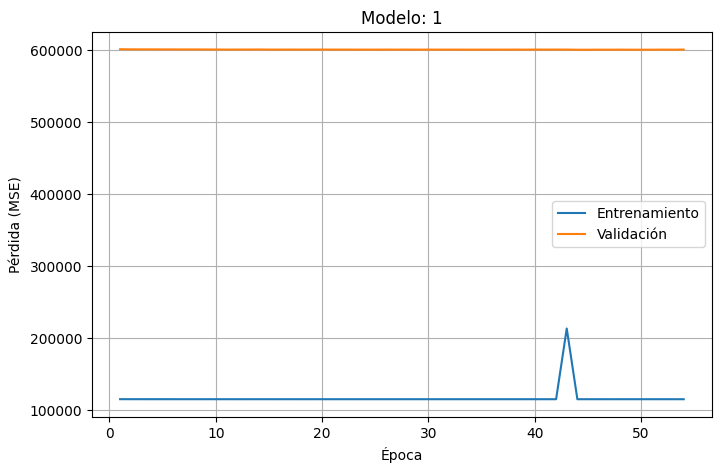

=
Epoch   0 | Train Loss: 115181.8561 | Val Loss: 600337.6400
Epoch   1 | Train Loss: 115175.5651 | Val Loss: 600264.9958
Epoch   2 | Train Loss: 115169.8282 | Val Loss: 600260.9306
Epoch   3 | Train Loss: 115171.2623 | Val Loss: 600239.5992
Epoch   4 | Train Loss: 115172.6800 | Val Loss: 600238.2925
Epoch   5 | Train Loss: 115170.9442 | Val Loss: 600198.7259
Epoch   6 | Train Loss: 115173.1932 | Val Loss: 600224.6281
Epoch   7 | Train Loss: 115170.6947 | Val Loss: 600211.5491
Epoch   8 | Train Loss: 115172.5614 | Val Loss: 600260.7254
Epoch   9 | Train Loss: 115169.7548 | Val Loss: 600248.6960
Epoch  10 | Train Loss: 115172.3037 | Val Loss: 600177.0746
Epoch  11 | Train Loss: 115171.3719 | Val Loss: 600158.3025
Epoch  12 | Train Loss: 115167.1752 | Val Loss: 600167.3858
Epoch  13 | Train Loss: 115167.3203 | Val Loss: 600169.0306
Epoch  14 | Train Loss: 115167.8945 | Val Loss: 600149.1913
Epoch  15 | Train Loss: 115168.8197 | Val Loss: 600143.2453
Epoch  16 | Train Loss: 115165.0953 | 

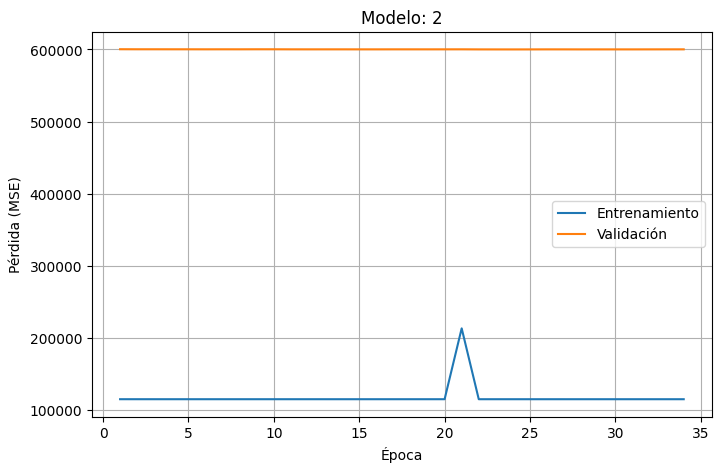

=
Epoch   0 | Train Loss: 114597.3289 | Val Loss: 601470.4865
Epoch   1 | Train Loss: 115223.6256 | Val Loss: 601477.5839
Epoch   2 | Train Loss: 114716.9450 | Val Loss: 601339.9585
Epoch   3 | Train Loss: 114606.7885 | Val Loss: 601286.5999
Epoch   4 | Train Loss: 114691.3055 | Val Loss: 601311.8641
Epoch   5 | Train Loss: 212132.6806 | Val Loss: 601226.0918
Epoch   6 | Train Loss: 114517.2072 | Val Loss: 600860.1937
Epoch   7 | Train Loss: 115056.1976 | Val Loss: 600934.2052
Epoch   8 | Train Loss: 114550.2897 | Val Loss: 600852.5821
Epoch   9 | Train Loss: 114316.5876 | Val Loss: 601041.2809
Epoch  10 | Train Loss: 114205.7937 | Val Loss: 601336.8801
Epoch  11 | Train Loss: 115332.2471 | Val Loss: 601183.0177
Epoch  12 | Train Loss: 114406.8217 | Val Loss: 600792.3610
Epoch  13 | Train Loss: 114149.8753 | Val Loss: 601099.1188
Epoch  14 | Train Loss: 114445.8983 | Val Loss: 601081.5844
Epoch  15 | Train Loss: 114387.9034 | Val Loss: 601214.7808
Epoch  16 | Train Loss: 114615.4780 | 

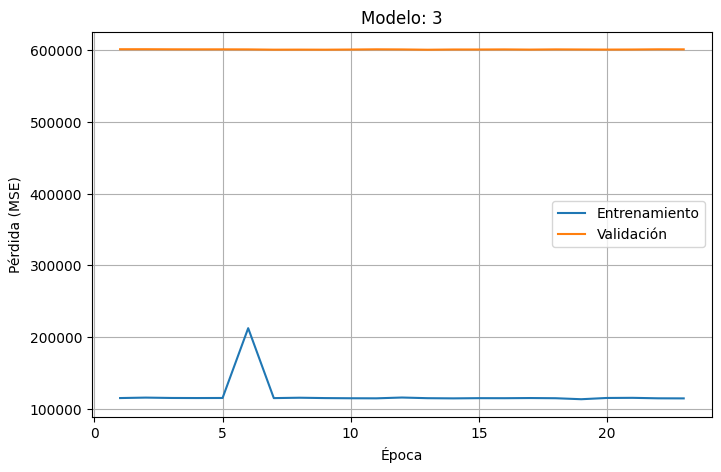

=
Epoch   0 | Train Loss: 114605.0948 | Val Loss: 601253.5924
Epoch   1 | Train Loss: 114322.4136 | Val Loss: 601005.1021
Epoch   2 | Train Loss: 114164.3597 | Val Loss: 600829.2210
Epoch   3 | Train Loss: 212316.2842 | Val Loss: 600957.0011
Epoch   4 | Train Loss: 114486.0060 | Val Loss: 600811.9059
Epoch   5 | Train Loss: 114458.6207 | Val Loss: 600802.2312
Epoch   6 | Train Loss: 114348.8865 | Val Loss: 600936.0739
Epoch   7 | Train Loss: 114492.6410 | Val Loss: 600517.3635
Epoch   8 | Train Loss: 116525.1937 | Val Loss: 600702.8569
Epoch   9 | Train Loss: 114185.0832 | Val Loss: 601155.6045
Epoch  10 | Train Loss: 114188.4787 | Val Loss: 600835.0512
Epoch  11 | Train Loss: 114283.2049 | Val Loss: 600841.4974
Epoch  12 | Train Loss: 114076.0162 | Val Loss: 600857.2927
Epoch  13 | Train Loss: 114386.2784 | Val Loss: 600833.9032
Epoch  14 | Train Loss: 114627.0055 | Val Loss: 600804.4135
Epoch  15 | Train Loss: 114236.3887 | Val Loss: 600786.1639
Epoch  16 | Train Loss: 114389.0905 | 

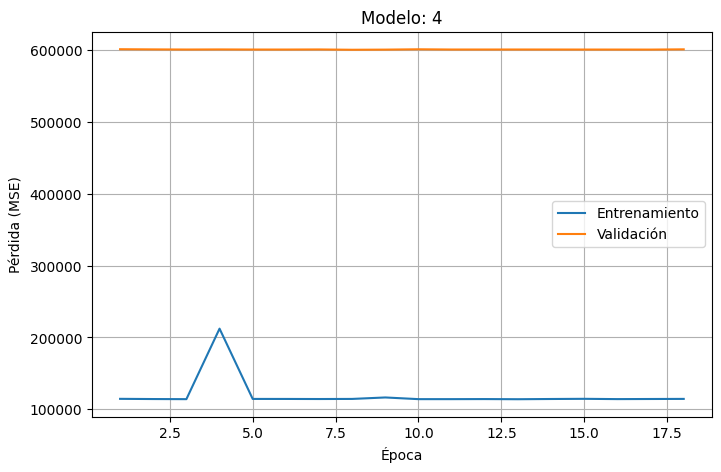

=


In [ ]:
trained_models = []

for model in models:
  model, train_losses, val_losses = train_model_early_stop(train_dl, val_dl, model, epochs=100, lr=0.001, patience=10)
  plot_learning_curves(train_losses, val_losses, title=f"Modelo: {models.index(model)+1}")
  trained_models.append(model)
  print("=")

# Pregunta 6

6. Realice la evaluación de todos los modelos utilizando R2
 y MAE. Presente una tabla
comparativa con los resultados de los MLP y los resultados de regresión lineal y polinómica
de la TP01. Genere dos conclusiones al respecto (3 puntos).


## Explicación ##

### Conclusión 1:
El modelo de regresión polinomial de grado 5 presentó un desempeño sobresaliente (R² ≈ 1), lo que indica un ajuste casi perfecto a los datos, superando ampliamente tanto a la regresión lineal como a los modelos de MLP.

### Conclusión 2:
Aunque los modelos MLP presentan MAE absolutos moderados (~173 a ~184), su error porcentual respecto al rango de salida (entre 1.68% y 1.78%) revela que, en promedio, el error es pequeño en relación con la escala del problema. Sin embargo, no compensa su mal desempeño en R2

In [ ]:
def evaluate_model(test_dl, model, target_min, target_max):
    """
    Evaluates the performance of a regression model on a test dataset.
    Calculates MSE, RMSE, MAE, and normalized error metrics
    relative to the range of the target variable.
    Returns a Dictionary with evaluation metrics: MSE, RMSE, MAE,
    MAE as % of range, and RMSE as % of range.
    Params:test_dl (DataLoader): Dataloader for the test dataset.
        model: Trained PyTorch model.
        target_min: Minimum possible value of the target.
        target_max: Maximum possible value of the target.
    """
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for inputs, targets in test_dl:
            inputs = inputs.float()
            targets = targets.float()

            yhat = model(inputs)
            yhat = yhat.detach().numpy().reshape(-1, 1)
            actual = targets.numpy().reshape(-1, 1)

            predictions.append(yhat)
            actuals.append(actual)

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    r2 = r2_score(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    target_range = target_max - target_min
    mae_pct = (mae / target_range) * 100
    rmse_pct = (rmse / target_range) * 100

    return {
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAE_%_of_range': mae_pct,
        'RMSE_%_of_range': rmse_pct
    }

In [ ]:
target_min = df['Rings'].min()
target_max = df['Rings'].max()

for trained_model in trained_models:
  metrics = evaluate_model(test_dl, trained_model, target_min, target_max)
  tp_01_r2_lin_reg = 0.5493012236956789
  tp_01_r2_poly =0.999999999999997
  print("R2 Regresión lineal TP01: ", tp_01_r2_lin_reg)
  print("R2 Polinomio TP01 (Grado 5): ", tp_01_r2_poly)
  print(f"Modelo {trained_models.index(trained_model)+1}:")
  for k, v in metrics.items():
      print(f"{k}: {v:.4f}")
  print("="*100)

R2 Regresión lineal TP01:  0.5493012236956789
R2 Polinomio TP01 (Grado 5):  0.999999999999997
Modelo 1:
R2: -0.0166
MSE: 1391090.6250
RMSE: 1179.4450
MAE: 179.5801
MAE_%_of_range: 1.7435
RMSE_%_of_range: 11.4509
R2 Regresión lineal TP01:  0.5493012236956789
R2 Polinomio TP01 (Grado 5):  0.999999999999997
Modelo 2:
R2: -0.0167
MSE: 1391189.3750
RMSE: 1179.4869
MAE: 178.7986
MAE_%_of_range: 1.7359
RMSE_%_of_range: 11.4513
R2 Regresión lineal TP01:  0.5493012236956789
R2 Polinomio TP01 (Grado 5):  0.999999999999997
Modelo 3:
R2: -0.0119
MSE: 1384576.0000
RMSE: 1176.6801
MAE: 183.9001
MAE_%_of_range: 1.7854
RMSE_%_of_range: 11.4241
R2 Regresión lineal TP01:  0.5493012236956789
R2 Polinomio TP01 (Grado 5):  0.999999999999997
Modelo 4:
R2: -0.0152
MSE: 1389098.5000
RMSE: 1178.6002
MAE: 173.3417
MAE_%_of_range: 1.6829
RMSE_%_of_range: 11.4427


# Pregunta 7

7. Realice un scatter plot para comparar el número de anillos de los abulones (valor
conocido) vs el número de anillos predicho por el mejor modelo de MLP (2 puntos).


## Explicación ##

Se utiliza el modelo con mejor MSE (que sería el cuarto modelo).
Además, se crea una función que obtiene las predicciones del modelo.

In [ ]:
def get_predictions(model, test_dl):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for inputs, targets in test_dl:
            inputs = inputs.float()
            targets = targets.float()

            yhat = model(inputs).detach().numpy().reshape(-1)
            actual = targets.numpy().reshape(-1)

            predictions.append(yhat)
            actuals.append(actual)

    y_pred = np.concatenate(predictions)
    y_true = np.concatenate(actuals)
    return y_true, y_pred

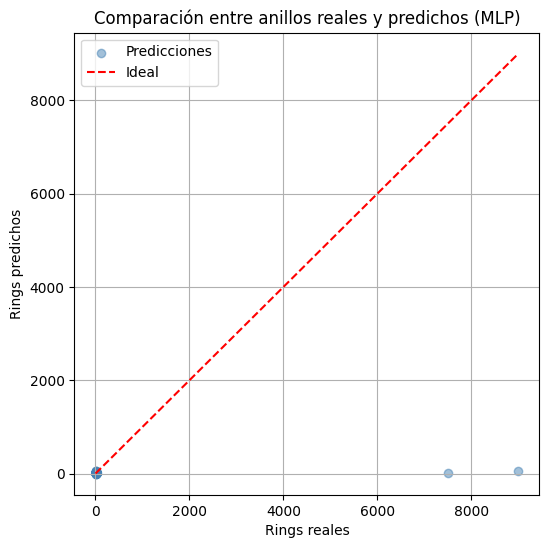

In [ ]:
best_model = trained_models[3] #el último modelo tiene mejor MSE


y_true, y_pred = get_predictions(best_model, test_dl)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color='steelblue', label='Predicciones')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal')
plt.xlabel('Rings reales')
plt.ylabel('Rings predichos')
plt.title('Comparación entre anillos reales y predichos (MLP)')
plt.legend()
plt.grid(True)
plt.show()

# Pregunta 8

8. (Para presentar en clase) Investigue el fundamento matemático del algoritmo para
clasificación multi-clase con “Máquinas de Vectores de Soporte (SVM)” y presente en clase
un cuaderno de Jupyter con la explicación del método (en celdas Markdown con fórmulas y
gráficos) y la aplicación del método a un conjunto de datos de su preferencia.


## SVM: Formulación Matemática Simple

Dado un conjunto de datos de entrenamiento:

$$
\{(\mathbf{x}_i, y_i)\}_{i=1}^n,\quad \mathbf{x}_i \in \mathbb{R}^d,\quad y_i \in \{-1, 1\}
$$

El objetivo es encontrar el hiperplano que separa las clases con el mayor margen. El problema de optimización es:

$$
\min_{\mathbf{w}, b} \ \frac{1}{2} \|\mathbf{w}\|^2
$$

sujeto a:

$$
y_i (\mathbf{w}^\top \mathbf{x}_i + b) \geq 1,\quad \text{para todo } i
$$

**Donde:**

- **w** es el vector de pesos (normal al hiperplano)  
- **b** es el sesgo (bias)


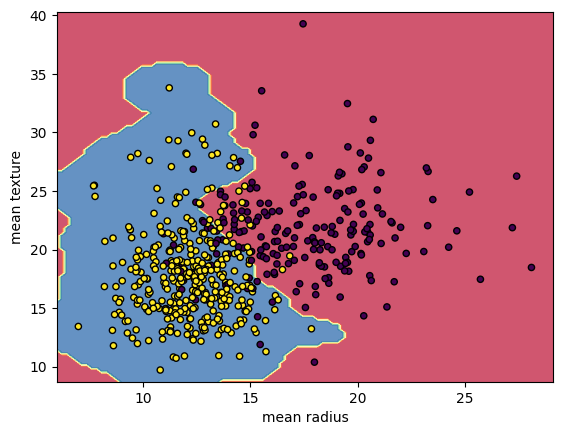

In [ ]:
# Load the important packages
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

# Load the datasets
cancer = load_breast_cancer()
X = cancer.data[:, :2]
y = cancer.target

#Build the model
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
# Trained the model
svm.fit(X, y)

# Plot Decision Boundary
DecisionBoundaryDisplay.from_estimator(
        svm,
        X,
        response_method="predict",
        cmap=plt.cm.Spectral,
        alpha=0.8,
        xlabel=cancer.feature_names[0],
        ylabel=cancer.feature_names[1],
    )

# Scatter plot
plt.scatter(X[:, 0], X[:, 1],
            c=y,
            s=20, edgecolors="k")
plt.show()